In [53]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime

In [54]:
df_patients = pd.read_excel('epic.xlsx', sheet_name=0)
df_admissions = pd.read_excel('epic.xlsx', sheet_name=1)
df_icu_stays = pd.read_excel('epic.xlsx', sheet_name=2)
df_bypass_surgeries = pd.read_excel('epic.xlsx', sheet_name=3)
df_haemoglobins = pd.read_excel('epic.xlsx', sheet_name=4)
df_transfusions = pd.read_excel('epic.xlsx', sheet_name=5)

In [55]:
df_haemoglobins['REFERENCE_LOW'] = df_haemoglobins['REFERENCE_LOW']/10
df_haemoglobins['REFERENCE_HIGH'] = df_haemoglobins['REFERENCE_HIGH']/10
df_haemoglobins['RESULT'] = df_haemoglobins['RESULT']/10

In [56]:
def df_admissions_patiens(packed_red_cells,name):
    female = packed_red_cells.loc[packed_red_cells.Gender == 'F' ].VOLUME
    male = packed_red_cells.loc[packed_red_cells.Gender == 'M' ].VOLUME
    plt.hist(male,  weights=np.ones_like(male) / len(male), edgecolor="black",label= f"male | {len(packed_red_cells.loc[packed_red_cells.Gender == 'M'])}")
    plt.hist(female,  weights=np.ones_like(female) / len(female),edgecolor="black",label= f"female | {len(packed_red_cells.loc[packed_red_cells.Gender == 'F'])}")
    plt.xlabel("Blood transfusion totalamount")
    plt.ylabel("Number of Patient")
    plt.title("Number of Patient in each group")
    plt.legend()
    plt.savefig(f'Bloodtransfusion_plots/{name}_histplot_bloodtransfusion_volume.png')
    plt.show()



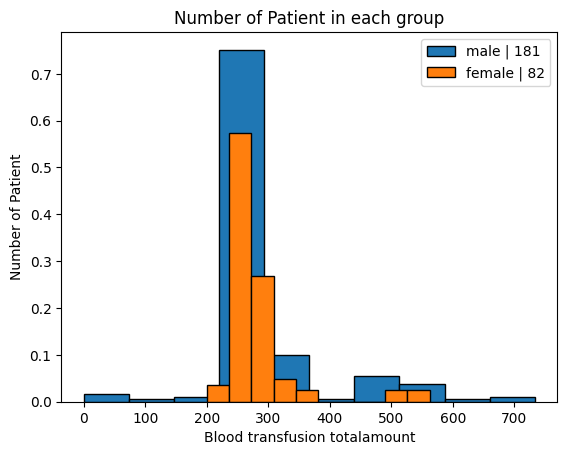

In [57]:
packed_red_cells = df_transfusions.join(df_patients.set_index('PATIENT_NUMBER'), on='PATIENT_NUMBER')
df_admissions_patiens(packed_red_cells, "EPIC")

In [58]:
blood_transfusion_count = df_transfusions.join(df_patients.set_index('PATIENT_NUMBER'), on='PATIENT_NUMBER')[["PATIENT_NUMBER", "Gender", "TRANSFUSION_NUMBER"]].groupby(["PATIENT_NUMBER", "Gender"]).count().reset_index()
blood_transfusion_count['counts'] = blood_transfusion_count['TRANSFUSION_NUMBER']

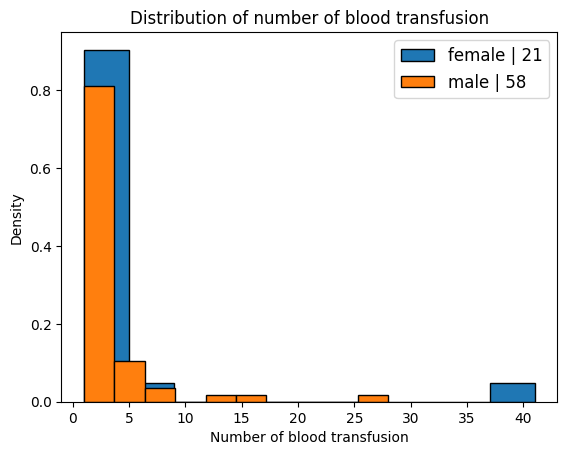

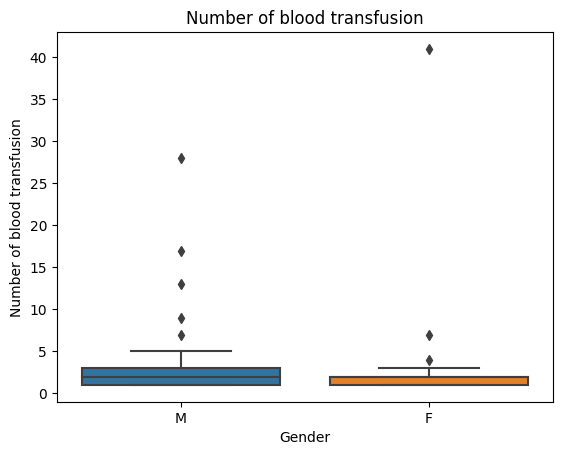

In [59]:
def histplot_bloodtransfusion_counts(blood_transfusion_count,name):
    
    
    female = blood_transfusion_count.loc[blood_transfusion_count.Gender == 'F' ].counts
    male = blood_transfusion_count.loc[blood_transfusion_count.Gender == 'M' ].counts
    plt.hist(female, weights=np.ones_like(female) / len(female), edgecolor="black",label= f"female | {len(blood_transfusion_count.loc[blood_transfusion_count.Gender == 'F'])}")
    plt.hist(male,  weights=np.ones_like(male) / len(male), edgecolor="black",label= f"male | {len(blood_transfusion_count.loc[blood_transfusion_count.Gender == 'M'])}")
    #plt.hist(female, weights=np.ones_like(female) / len(female), edgecolor="black",label= f"female | {len(blood_transfusion_count.loc[blood_transfusion_count.Gender == 'F'])}")
    
    plt.legend(prop={'size': 12})
    plt.title('Distribution of number of blood transfusion')
    plt.xlabel('Number of blood transfusion')
    plt.ylabel('Density')
    plt.savefig(f'Bloodtransfusion_plots/{name}_histplot_numberOfbloodTransfusion_gender.png')
    plt.show()
   

def boxplot_bloodtransfusion_counts(blood_transfusion_count,name):
    sns.boxplot(x="Gender", y='counts', data=blood_transfusion_count)
    plt.title("Number of blood transfusion")
    plt.ylabel('Number of blood transfusion')
    plt.savefig(f'Bloodtransfusion_plots/{name}_boxplot_numberOfbloodTransfusion_gender.png')
    plt.show()

histplot_bloodtransfusion_counts(blood_transfusion_count,"EPIC")
boxplot_bloodtransfusion_counts(blood_transfusion_count,"EPIC")

In [60]:
first_blood_transfusion = df_transfusions[df_transfusions.groupby("ADMISSION_NUMBER")['BLOOD_START_TIME'].rank() == 1].sort_values("ADMISSION_NUMBER")[["ADMISSION_NUMBER", "PATIENT_NUMBER", "BLOOD_START_TIME", "VOLUME"]]

result = first_blood_transfusion.join(blood_transfusion_count.set_index("PATIENT_NUMBER")[['counts']], on='PATIENT_NUMBER').rename(columns={"counts" : "blood_counts"})
result

,ADMISSION_NUMBER,PATIENT_NUMBER,BLOOD_START_TIME,VOLUME,blood_counts
115,2,268,2021-06-19 16:45:00,224.00,5
20,8,199,2022-03-12 13:22:00,255.00,2
211,12,1,2021-12-19 17:59:00,271.97,1
66,16,196,2022-04-26 07:00:00,278.00,3
142,18,64,2022-06-25 10:46:00,338.67,1
...,...,...,...,...,...
32,249,243,2022-03-11 03:49:00,382.00,1
57,252,56,2021-02-24 18:34:00,35.00,1
85,257,165,2021-05-08 10:06:00,518.00,2
108,259,128,2021-07-24 10:58:00,496.00,1


In [61]:
df1 = df_haemoglobins[['ADMISSION_NUMBER', 'RESULT', 'SPECIMEN_TAKEN_TIME']].join(result.set_index('ADMISSION_NUMBER'), on="ADMISSION_NUMBER").dropna()
df1 = df1[df1.SPECIMEN_TAKEN_TIME > df1.BLOOD_START_TIME]
df1 = df1[df1.groupby("ADMISSION_NUMBER")['SPECIMEN_TAKEN_TIME'].rank() == 1].rename(columns={"RESULT" : "post_transfusion", "SPECIMEN_TAKEN_TIME": "charttime_after"}).sort_values("ADMISSION_NUMBER").reset_index(drop=True)
df1

,ADMISSION_NUMBER,post_transfusion,charttime_after,PATIENT_NUMBER,BLOOD_START_TIME,VOLUME,blood_counts
0,2,8.2,2021-06-19 18:29:00,268.0,2021-06-19 16:45:00,224.00,5.0
1,8,11.3,2022-03-12 14:02:00,199.0,2022-03-12 13:22:00,255.00,2.0
2,12,8.4,2021-12-20 01:50:00,1.0,2021-12-19 17:59:00,271.97,1.0
3,16,7.6,2022-04-27 14:56:00,196.0,2022-04-26 07:00:00,278.00,3.0
4,18,8.9,2022-06-25 15:29:00,64.0,2022-06-25 10:46:00,338.67,1.0
...,...,...,...,...,...,...,...
57,249,8.3,2022-03-11 05:15:00,243.0,2022-03-11 03:49:00,382.00,1.0
58,252,8.0,2021-02-24 18:59:00,56.0,2021-02-24 18:34:00,35.00,1.0
59,257,8.6,2021-05-08 12:26:00,165.0,2021-05-08 10:06:00,518.00,2.0
60,259,8.8,2021-07-24 16:29:00,128.0,2021-07-24 10:58:00,496.00,1.0


In [62]:
df2 = df_haemoglobins[['ADMISSION_NUMBER', 'RESULT', 'SPECIMEN_TAKEN_TIME']].join(result.set_index('ADMISSION_NUMBER'), on="ADMISSION_NUMBER").dropna()
df2 = df2[df2.SPECIMEN_TAKEN_TIME < df2.BLOOD_START_TIME]

df2 = df2.sort_values('SPECIMEN_TAKEN_TIME').groupby('ADMISSION_NUMBER').last().sort_values("ADMISSION_NUMBER").reset_index().rename(columns = {"RESULT" : "pre_transfusion", "SPECIMEN_TAKEN_TIME": "charttime_before"})

df2

,ADMISSION_NUMBER,pre_transfusion,charttime_before,PATIENT_NUMBER,BLOOD_START_TIME,VOLUME,blood_counts
0,2,7.1,2021-06-19 16:24:00,268.0,2021-06-19 16:45:00,224.00,5.0
1,8,9.1,2022-03-12 12:52:00,199.0,2022-03-12 13:22:00,255.00,2.0
2,12,6.9,2021-12-19 04:35:00,1.0,2021-12-19 17:59:00,271.97,1.0
3,16,7.4,2022-04-26 06:42:00,196.0,2022-04-26 07:00:00,278.00,3.0
4,18,7.5,2022-06-25 05:49:00,64.0,2022-06-25 10:46:00,338.67,1.0
...,...,...,...,...,...,...,...
56,249,7.6,2022-03-11 00:01:00,243.0,2022-03-11 03:49:00,382.00,1.0
57,252,7.2,2021-02-24 17:51:00,56.0,2021-02-24 18:34:00,35.00,1.0
58,257,7.6,2021-05-08 02:04:00,165.0,2021-05-08 10:06:00,518.00,2.0
59,259,7.1,2021-07-24 02:35:00,128.0,2021-07-24 10:58:00,496.00,1.0


In [63]:
result = df2.drop(columns=["BLOOD_START_TIME", "VOLUME", "PATIENT_NUMBER", "blood_counts"]).join(df1.set_index("ADMISSION_NUMBER"), on="ADMISSION_NUMBER")
result

,ADMISSION_NUMBER,pre_transfusion,charttime_before,post_transfusion,charttime_after,PATIENT_NUMBER,BLOOD_START_TIME,VOLUME,blood_counts
0,2,7.1,2021-06-19 16:24:00,8.2,2021-06-19 18:29:00,268.0,2021-06-19 16:45:00,224.00,5.0
1,8,9.1,2022-03-12 12:52:00,11.3,2022-03-12 14:02:00,199.0,2022-03-12 13:22:00,255.00,2.0
2,12,6.9,2021-12-19 04:35:00,8.4,2021-12-20 01:50:00,1.0,2021-12-19 17:59:00,271.97,1.0
3,16,7.4,2022-04-26 06:42:00,7.6,2022-04-27 14:56:00,196.0,2022-04-26 07:00:00,278.00,3.0
4,18,7.5,2022-06-25 05:49:00,8.9,2022-06-25 15:29:00,64.0,2022-06-25 10:46:00,338.67,1.0
...,...,...,...,...,...,...,...,...,...
56,249,7.6,2022-03-11 00:01:00,8.3,2022-03-11 05:15:00,243.0,2022-03-11 03:49:00,382.00,1.0
57,252,7.2,2021-02-24 17:51:00,8.0,2021-02-24 18:59:00,56.0,2021-02-24 18:34:00,35.00,1.0
58,257,7.6,2021-05-08 02:04:00,8.6,2021-05-08 12:26:00,165.0,2021-05-08 10:06:00,518.00,2.0
59,259,7.1,2021-07-24 02:35:00,8.8,2021-07-24 16:29:00,128.0,2021-07-24 10:58:00,496.00,1.0


In [64]:
result = result.join(df_patients[['PATIENT_NUMBER', "Gender"]].set_index("PATIENT_NUMBER"), on="PATIENT_NUMBER").rename(columns = {"ADMISSION_NUMBER" : "hadm_id", "BLOOD_START_TIME": "first_blood_transfusion_starttime", "Gender": "gender"}).drop(columns=['VOLUME', "PATIENT_NUMBER"])
result


,hadm_id,pre_transfusion,charttime_before,post_transfusion,charttime_after,first_blood_transfusion_starttime,blood_counts,gender
0,2,7.1,2021-06-19 16:24:00,8.2,2021-06-19 18:29:00,2021-06-19 16:45:00,5.0,M
1,8,9.1,2022-03-12 12:52:00,11.3,2022-03-12 14:02:00,2022-03-12 13:22:00,2.0,M
2,12,6.9,2021-12-19 04:35:00,8.4,2021-12-20 01:50:00,2021-12-19 17:59:00,1.0,M
3,16,7.4,2022-04-26 06:42:00,7.6,2022-04-27 14:56:00,2022-04-26 07:00:00,3.0,M
4,18,7.5,2022-06-25 05:49:00,8.9,2022-06-25 15:29:00,2022-06-25 10:46:00,1.0,M
...,...,...,...,...,...,...,...,...
56,249,7.6,2022-03-11 00:01:00,8.3,2022-03-11 05:15:00,2022-03-11 03:49:00,1.0,M
57,252,7.2,2021-02-24 17:51:00,8.0,2021-02-24 18:59:00,2021-02-24 18:34:00,1.0,M
58,257,7.6,2021-05-08 02:04:00,8.6,2021-05-08 12:26:00,2021-05-08 10:06:00,2.0,F
59,259,7.1,2021-07-24 02:35:00,8.8,2021-07-24 16:29:00,2021-07-24 10:58:00,1.0,M


In [65]:
result['description'] = "Hemoglobin"
result['valueuom'] = "g/dL"
result['labevent_time_diff_min'] = (result.charttime_after - result.charttime_before).dt.seconds/60
result['labevent_before_tranfusion_diff_min'] = (result.first_blood_transfusion_starttime - result.charttime_before).dt.seconds/60
result['labevent_after_tranfusion_diff_min'] = (result.charttime_after - result.first_blood_transfusion_starttime).dt.seconds/60
result['value_diff'] = result.post_transfusion - result.pre_transfusion
result = result[['hadm_id', 'gender', 'description', 'pre_transfusion', 'post_transfusion', 'value_diff', 'valueuom', 'charttime_before', 'first_blood_transfusion_starttime', 'charttime_after', 'labevent_time_diff_min', 'labevent_before_tranfusion_diff_min', 'labevent_after_tranfusion_diff_min', 'blood_counts']]

In [41]:
result

,hadm_id,gender,description,pre_transfusion,post_transfusion,value_diff,valueuom,charttime_before,first_blood_transfusion_starttime,charttime_after,labevent_time_diff_min,labevent_before_tranfusion_diff_min,labevent_after_tranfusion_diff_min,blood_counts
0,2,M,Hemoglobin,7.1,8.2,1.1,g/dL,2021-06-19 16:24:00,2021-06-19 16:45:00,2021-06-19 18:29:00,125.0,21.0,104.0,5.0
1,8,M,Hemoglobin,9.1,11.3,2.2,g/dL,2022-03-12 12:52:00,2022-03-12 13:22:00,2022-03-12 14:02:00,70.0,30.0,40.0,2.0
2,12,M,Hemoglobin,6.9,8.4,1.5,g/dL,2021-12-19 04:35:00,2021-12-19 17:59:00,2021-12-20 01:50:00,1275.0,804.0,471.0,1.0
3,16,M,Hemoglobin,7.4,7.6,0.2,g/dL,2022-04-26 06:42:00,2022-04-26 07:00:00,2022-04-27 14:56:00,494.0,18.0,476.0,3.0
4,18,M,Hemoglobin,7.5,8.9,1.4,g/dL,2022-06-25 05:49:00,2022-06-25 10:46:00,2022-06-25 15:29:00,580.0,297.0,283.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,249,M,Hemoglobin,7.6,8.3,0.7,g/dL,2022-03-11 00:01:00,2022-03-11 03:49:00,2022-03-11 05:15:00,314.0,228.0,86.0,1.0
57,252,M,Hemoglobin,7.2,8.0,0.8,g/dL,2021-02-24 17:51:00,2021-02-24 18:34:00,2021-02-24 18:59:00,68.0,43.0,25.0,1.0
58,257,F,Hemoglobin,7.6,8.6,1.0,g/dL,2021-05-08 02:04:00,2021-05-08 10:06:00,2021-05-08 12:26:00,622.0,482.0,140.0,2.0
59,259,M,Hemoglobin,7.1,8.8,1.7,g/dL,2021-07-24 02:35:00,2021-07-24 10:58:00,2021-07-24 16:29:00,834.0,503.0,331.0,1.0


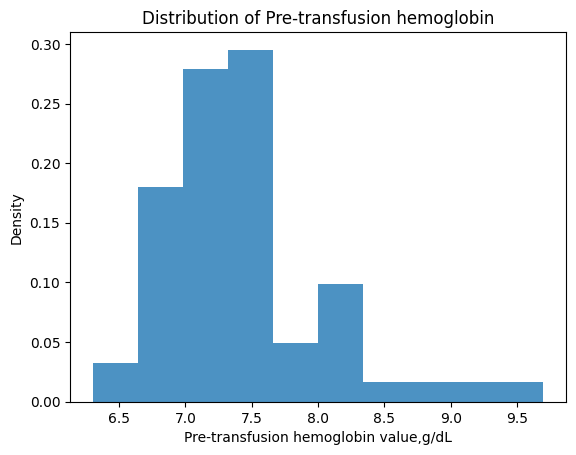

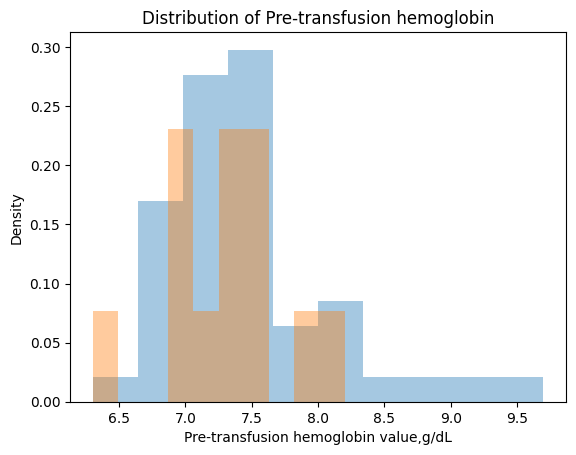

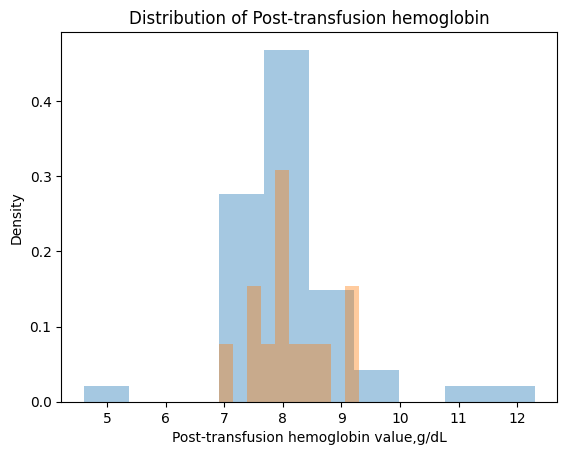

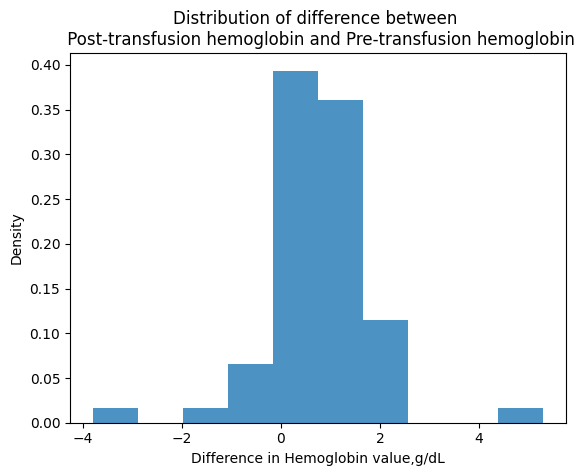

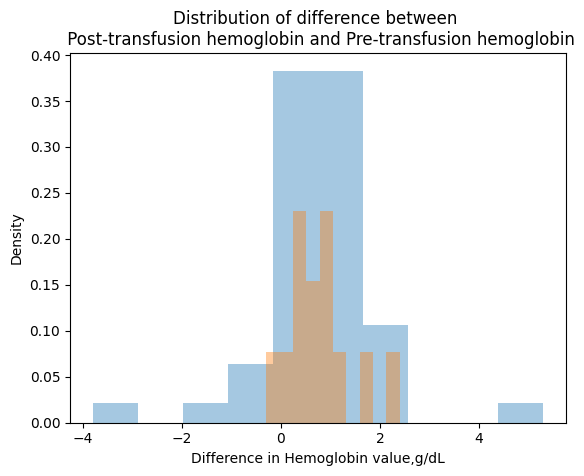

In [68]:

def get_hemoglobin_distribution(hemoglobin,name):

    
    #sns.displot(data=hemoglobin, x="pre_transfusion", stat="density")
    plt.hist(hemoglobin.pre_transfusion,alpha=0.8, linewidth=1, weights=np.ones_like(hemoglobin.pre_transfusion) / len(hemoglobin.pre_transfusion))


    #plt.legend(prop={'size': 12})
    plt.title('Distribution of Pre-transfusion hemoglobin')
    plt.xlabel('Pre-transfusion hemoglobin value,g/dL')
    plt.ylabel('Density')
    plt.savefig(f'labevent_plots/{name}_Distribution_of_Pre-transfusion_hemoglobin.png')
    plt.show()
    
#     sns.displot(data=hemoglobin, x="pre_transfusion",hue ='gender', stat="density")
    female = hemoglobin.loc[hemoglobin.gender == 'F' ].pre_transfusion
    male = hemoglobin.loc[hemoglobin.gender == 'M' ].pre_transfusion
    plt.hist(male, alpha=0.4, linewidth=0, weights=np.ones_like(male) / len(male),edgecolor="black",label= f"male | {len(hemoglobin.loc[hemoglobin.gender == 'M'])}")
    plt.hist(female,alpha=0.4,linewidth=0, weights=np.ones_like(female) / len(female), edgecolor="black",label= f"female | {len(hemoglobin.loc[hemoglobin.gender == 'F'])}")
    


    #plt.legend(prop={'size': 12})
    plt.title('Distribution of Pre-transfusion hemoglobin')
    plt.xlabel('Pre-transfusion hemoglobin value,g/dL')
    plt.ylabel('Density')
    
    plt.savefig(f'labevent_plots/{name}_Distribution_of_Post-transfusion_hemoglobin_gender.png')
    plt.show()
    
    
#     sns.displot(data=hemoglobin, x="post_transfusion",hue ='gender', stat="density")
    female = hemoglobin.loc[hemoglobin.gender == 'F' ].post_transfusion
    male = hemoglobin.loc[hemoglobin.gender == 'M' ].post_transfusion
    plt.hist(male,   alpha=0.4, linewidth=0, weights=np.ones_like(male) / len(male),edgecolor="black",label= f"male | {len(hemoglobin.loc[hemoglobin.gender == 'M'])}")
    plt.hist(female, alpha=0.4, linewidth=0, weights=np.ones_like(female) / len(female), edgecolor="black",label= f"female | {len(hemoglobin.loc[hemoglobin.gender == 'F'])}")
    


    #plt.legend(prop={'size': 12})
    plt.title('Distribution of Post-transfusion hemoglobin')
    plt.xlabel('Post-transfusion hemoglobin value,g/dL')
    plt.ylabel('Density')
    plt.savefig(f'labevent_plots/{name}_Distribution_of_Post-transfusion_hemoglobin_gender.png')
    plt.show()  
    
    
    
    #sns.displot(data=hemoglobin, x="value_diff", stat="density")
    plt.hist(hemoglobin.value_diff,alpha=0.8, weights=np.ones_like(hemoglobin.value_diff) / len(hemoglobin.value_diff))


    #plt.legend(prop={'size': 12})
    plt.title('Distribution of difference between \n Post-transfusion hemoglobin and Pre-transfusion hemoglobin')
    plt.xlabel('Difference in Hemoglobin value,g/dL')
    plt.ylabel('Density')
    plt.savefig(f'labevent_plots/{name}_Distribution_of_value_diff_hemoglobin.png')
    plt.show()
    
    
#     sns.displot(data=hemoglobin, x="value_diff",hue ='gender', stat="density")
    female = hemoglobin.loc[hemoglobin.gender == 'F' ].value_diff
    male = hemoglobin.loc[hemoglobin.gender == 'M' ].value_diff
    plt.hist(male,   alpha=0.4, linewidth=0, weights=np.ones_like(male) / len(male),edgecolor="black",label= f"male | {len(hemoglobin.loc[hemoglobin.gender == 'M'])}")
    plt.hist(female, alpha=0.4, linewidth=0, weights=np.ones_like(female) / len(female), edgecolor="black",label= f"female | {len(hemoglobin.loc[hemoglobin.gender == 'F'])}")
    
    #plt.legend(prop={'size': 12})
    plt.title('Distribution of difference between \n Post-transfusion hemoglobin and Pre-transfusion hemoglobin')
    plt.xlabel('Difference in Hemoglobin value,g/dL')
    plt.ylabel('Density')
    plt.savefig(f'labevent_plots/{name}_Distribution_of_value_diff_hemoglobin_gender.png')
    plt.show()
    
get_hemoglobin_distribution(result,'EPIC')    

In [14]:
def scatter_ValueDiff_Pretransfusion(df,name):
    plt.figure(figsize=(7,7))
    sns.scatterplot(data=df, x="pre_transfusion", y="value_diff", hue="gender")
    plt.xlabel('Pre-transfusion value')
    plt.ylabel("Value diff")
    plt.title("Value Diff vs Pre-transfusion")
    plt.savefig(f'labevent_plots/{name}_scatter_ValueDiff_Pretransfusion.png')
    plt.show()

def scatter_ValueDiff_Posttransfusion(df,name):
    plt.figure(figsize=(7,7))
    sns.scatterplot(data=df, x="post_transfusion", y="value_diff", hue="gender")
    plt.xlabel('Post-transfusion value')
    plt.ylabel("Value diff")
    plt.title("Value diff vs Post-transfusion, in g/dL")
    plt.savefig(f'labevent_plots/{name}_scatter_ValueDiff_Posttransfusion.png')
    plt.show()
    
def scatter_Counts_Pretransfusion(df,name):
    plt.figure(figsize=(7,7))
    sns.scatterplot(data=df, x="pre_transfusion", y="blood_counts", hue="gender")
    plt.xlabel('Pre-transfusion value')
    plt.ylabel("Blood transfusion counts")
    plt.title("Blood transfusion counts vs Pre-transfusion, in g/dL")
    plt.savefig(f'labevent_plots/{name}_scatter_Counts_Pretransfusion.png')
    plt.show()
    
def boxplot_Pretransfusion_Bloodtransfusion(df,name):
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=df, x='blood_counts', y='pre_transfusion')
    plt.ylabel('Pre-transfusion value')
    plt.xlabel("Blood transfusion counts")
    plt.savefig(f'labevent_plots/{name}_boxplot_Pretransfusion_Bloodtransfusion.png')
    plt.show()

def boxplot_Posttransfusion_Bloodtransfusion(df,name):
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=df, x='blood_counts', y='post_transfusion')
    plt.savefig(f'labevent_plots/{name}_boxplot_Posttransfusion_Bloodtransfusion.png')
    plt.show()

def multiline_Pretransfusion_Bloodtransfusion(df,name):
    row = 3
    col = 1
    fig, axes = plt.subplots(row,sharex=True, figsize=(16,8))
    fig.suptitle('Pre-transfusion value for patient with different number of blood transfusion')


    for axes_num1 in range(3):

        count = axes_num1+1

        if(count==3):
            partial_fbt_time_differece_Hb = df.loc[(df.blood_counts >= count)]
        else:
            partial_fbt_time_differece_Hb = df.loc[(df.blood_counts == count)]


        sns.kdeplot(ax=axes[axes_num1],x= partial_fbt_time_differece_Hb['pre_transfusion'],label='All')
        mean= partial_fbt_time_differece_Hb.mean().pre_transfusion

        if(count==3):
            axes[axes_num1].set_title('Blood transfusion >='+str(count)+ '|Patients '+str(len(partial_fbt_time_differece_Hb))+'| Mean ' + str(round(mean,3)))
        else:
            axes[axes_num1].set_title('Blood transfusion '+str(count)+ '|Patients '+str(len(partial_fbt_time_differece_Hb))+'| Mean ' + str(round(mean,3)))

        axes[2].set_xlabel("Pre-transfusion value")
        axes[axes_num1].legend(loc='upper right')
    fig.savefig(f'labevent_plots/{name}_multiline_Pretransfusion_Bloodtransfusion.png')
    fig.show()

def multiline_Pretransfusion_Bloodtransfusion_gender(df,name):
    row = 3
    col = 1
    fig, axes = plt.subplots(row,sharex=True, figsize=(16,8))
    fig.suptitle('Pre-transfusion value for patient with different number of blood transfusion')


    for axes_num1 in range(3):
        count = axes_num1+1

        if(count==3):
            partial_fbt_time_differece_Hb = df.loc[(df.blood_counts >= count)]
        else:
            partial_fbt_time_differece_Hb = df.loc[(df.blood_counts == count)]

        male_Hb = partial_fbt_time_differece_Hb[partial_fbt_time_differece_Hb.gender == 'M']
        sns.kdeplot(ax=axes[axes_num1],x=male_Hb['pre_transfusion'], label='male')
        female_Hb =partial_fbt_time_differece_Hb[partial_fbt_time_differece_Hb.gender == 'F']
        sns.kdeplot(ax=axes[axes_num1],x=female_Hb['pre_transfusion'],label='female')
        sns.kdeplot(ax=axes[axes_num1],x= partial_fbt_time_differece_Hb['pre_transfusion'],label='All')
        mean= partial_fbt_time_differece_Hb.mean().pre_transfusion
        fmean = female_Hb.pre_transfusion.mean()
        mmean= male_Hb.pre_transfusion.mean()

        if(count==3):
            axes[axes_num1].set_title('Blood transfusion >='+str(count)+ '|Patients '+str(len(partial_fbt_time_differece_Hb))+ '| Mean ' + str(round(mean,3)) +'| F Mean '+str(round(fmean,3)) + '| M Mean '+str(round(mmean,3)))
        else:
            axes[axes_num1].set_title('Blood transfusion '+str(count)+ '|Patients '+str(len(partial_fbt_time_differece_Hb))+'| Mean ' + str(round(mean,3)) +'| F Mean '+str(round(fmean,3)) + '| M Mean '+str(round(mmean,3)))


        axes[2].set_xlabel("Pre-transfusion value")
        axes[axes_num1].legend(loc='upper right')
    fig.savefig(f'labevent_plots/{name}_multiline_Pretransfusion_Bloodtransfusion_gender.png')
    fig.show()

def multiline_Posttransfusion_Bloodtransfusion_gender(df,name):
    row = 3
    col = 1
    fig, axes = plt.subplots(row,sharex=True, figsize=(16,8))
    fig.suptitle('Post-transfusion value for patient with different number of blood transfusion')


    for axes_num1 in range(3):
        count = axes_num1+1

        if(count==3):
            partial_fbt_time_differece_Hb = df.loc[(df.blood_counts >= count)]
        else:
            partial_fbt_time_differece_Hb = df.loc[(df.blood_counts == count)]

        male_Hb = partial_fbt_time_differece_Hb[partial_fbt_time_differece_Hb.gender == 'M']
        sns.kdeplot(ax=axes[axes_num1],x=male_Hb['post_transfusion'], label='male')
        female_Hb =partial_fbt_time_differece_Hb[partial_fbt_time_differece_Hb.gender == 'F']
        sns.kdeplot(ax=axes[axes_num1],x=female_Hb['post_transfusion'],label='female')
        sns.kdeplot(ax=axes[axes_num1],x= partial_fbt_time_differece_Hb['post_transfusion'],label='All')
        mean= partial_fbt_time_differece_Hb.mean().post_transfusion
        fmean = female_Hb.pre_transfusion.mean()
        mmean= male_Hb.pre_transfusion.mean()

        if(count==3):
            axes[axes_num1].set_title('Blood transfusion >='+str(count)+  '|Patients '+str(len(partial_fbt_time_differece_Hb))+ '| Mean ' + str(round(mean,3))+'| F Mean '+str(round(fmean,3)) + '| M Mean '+str(round(mmean,3)))
        else:
            axes[axes_num1].set_title('Blood transfusion '+str(count)+ '|Patients '+str(len(partial_fbt_time_differece_Hb))+'| Mean ' + str(round(mean,3))+'| F Mean '+str(round(fmean,3)) +'| M Mean '+str(round(mmean,3)))


        axes[2].set_xlabel("Post_transfusion value")
        axes[axes_num1].legend(loc='upper right')
    fig.savefig(f'labevent_plots/{name}_multiline_Posttransfusion_Bloodtransfusion_gender.png')
    fig.show()
        
def multiline_valuediff_Bloodtransfusion_gender(df,name):
    #value_diff
    row = 3
    col = 1
    fig, axes = plt.subplots(row,sharex=True, figsize=(16,8))
    fig.suptitle('Value Diff for patient with different number of blood transfusion')


    for axes_num1 in range(3):
        count = axes_num1+1

        if(count==3):
            partial_fbt_time_differece_Hb = df.loc[(df.blood_counts >= count)]
        else:
            partial_fbt_time_differece_Hb = df.loc[(df.blood_counts == count)]

        male_Hb = partial_fbt_time_differece_Hb[partial_fbt_time_differece_Hb.gender == 'M']
        sns.kdeplot(ax=axes[axes_num1],x=male_Hb['value_diff'], label='male')
        female_Hb =partial_fbt_time_differece_Hb[partial_fbt_time_differece_Hb.gender== 'F']
        sns.kdeplot(ax=axes[axes_num1],x=female_Hb['value_diff'],label='female')
        sns.kdeplot(ax=axes[axes_num1],x= partial_fbt_time_differece_Hb['value_diff'],label='All')
        mean= partial_fbt_time_differece_Hb.mean().value_diff
        fmean = female_Hb.pre_transfusion.mean()
        mmean= male_Hb.pre_transfusion.mean()

        if(count==3):
            axes[axes_num1].set_title('Blood transfusion >='+str(count)+ '|Patients '+str(len(partial_fbt_time_differece_Hb))+'| Mean ' + str(round(mean,3)) +'| F Mean '+str(round(fmean,3)) +'| M Mean '+str(round(mmean,3)))
        else:
            axes[axes_num1].set_title('Blood transfusion '+str(count)+ '|Patients '+str(len(partial_fbt_time_differece_Hb))+'| Mean ' + str(round(mean,3)) +'| F Mean '+str(round(fmean,3)) +'| M Mean '+str(round(mmean,3)))


        axes[2].set_xlabel("Value Diff")
        axes[axes_num1].legend(loc='upper right')
    fig.savefig(f'labevent_plots/{name}_multiline_valuediff_Bloodtransfusion_gender.png')
    fig.show()
        
def boxplot_Pretransfusion_Bloodtransfusion_gender(df,name):
    
    plt.figure(figsize=(7, 7))
    sns.boxplot(data=df, x='blood_counts', y='pre_transfusion', hue="gender")
    plt.xlabel("Blood counts", fontsize=14)
    plt.ylabel("Pre transfusion", fontsize=14)
    plt.title("Pre transfusion by blood counts & gender Group")
    plt.savefig(f'labevent_plots/{name}_boxplot_Pretransfusion_Bloodtransfusion_gender.png')
    plt.show()
    
        
def scatter_Pretransfusion_PreFbtTime(df,name):
    plt.figure(figsize=(7,7))
    sns.scatterplot(data=df, y="labevent_before_tranfusion_diff_min", x="pre_transfusion", hue="gender")
    plt.xlabel('Pre-transfusion value')
    plt.ylabel("Time between Pre-transfusion and first blood transfusion, in Minutes")
    plt.title("Pre-transfusion value vs time \n between Pre-transfusion and first blood transfusion")
    plt.savefig(f'labevent_plots/{name}_scatter_Pretransfusion_PreFbtTime.png')
    plt.show()  
    
    
def scatter_Posttransfusion_FbtPostTime(df,name):
    plt.figure(figsize=(7,7))
    sns.scatterplot(data=df, y="labevent_after_tranfusion_diff_min", x="post_transfusion", hue="gender")
    plt.ylabel('Time between blood transfusion and Post-transfusion, in Minutes')
    plt.xlabel("Post-transfusion value")
    plt.title("Post-transfusion value vs Time \n between blood transfusion and Post-transfusion")
    plt.savefig(f'labevent_plots/{name}_scatter_Posttransfusion_FbtPostTime.png')
    plt.show()  
    
def scatter_Valuediff_PrePostTime(df,name):
    plt.figure(figsize=(7,7))
    sns.scatterplot(data=df, y="labevent_time_diff_min", x="value_diff", hue="gender")
    plt.ylabel('Time between pre-transfusion  and post-transfusion, in Minutes')
    plt.xlabel("Value diff")
    plt.title("Measurement Difference (Before and After, in g/dL)")
    plt.savefig(f'labevent_plots/{name}_scatter_Valuediff_PrePostTime.png')
    plt.show()  
    
def scatter_Valuediff_FbtPostTime(df,name):
    plt.figure(figsize=(7,7))
    sns.scatterplot(data=df, y="labevent_after_tranfusion_diff_min", x="value_diff", hue="gender")
    plt.xlabel('Value diff')
    plt.ylabel("Time between first blood transfusion and post-transfusion, in Minutes")
    plt.title("Measurement Difference (Before and After, in g/dL)")
    plt.savefig(f'labevent_plots/{name}_scatter_Valuediff_FbtPostTime.png')
    plt.show()  
    

def histplot_PosttransfusionTime(df,name):
    plt.figure(figsize=(7,7))
    sns.histplot(data=df, x="labevent_after_tranfusion_diff_min", kde=True)
    plt.xlabel("Time difference first blood transfusion and post-transfusion, in Minutes")
    plt.title("Time difference between first blood transfusion and post-transfusion, in Minutes")
    plt.savefig(f'labevent_plots/{name}_histplot_PosttransfusionTime.png')
    plt.show()   
    

def boxplot_PosttransfusionTime(df,name):
    sns.boxplot(x="gender", y="labevent_after_tranfusion_diff_min", data=df)
    plt.title("Time difference between first blood transfusion and post-transfusion, in Minutes")
    plt.ylabel("Time difference ")
    plt.savefig(f'labevent_plots/{name}_boxplot_PosttransfusionTime.png')
    plt.show()   
    
def histplot_PretransfusionTime(df,name):
    plt.figure(figsize=(7,7))
    sns.histplot(data=df, x="labevent_before_tranfusion_diff_min", kde=True)
    plt.xlabel("Time between pre-transfusion and first blood transfusion, in Minutes")
    plt.title("Time difference between pre-transfusion and first blood transfusion, in Minutes")
    plt.savefig(f'labevent_plots/{name}_histplot_PretransfusionTime.png')
    plt.show()   

    
def boxplot_PretransfusionTime(df,name):
    sns.boxplot(x="gender", y="labevent_before_tranfusion_diff_min", data=df)
    plt.title("Time difference between pre-transfusion and first blood transfusion, in Minutes")
    plt.ylabel("Time difference ")
    plt.savefig(f'labevent_plots/{name}_boxplot_PretransfusionTime.png')
    plt.show()   
    
    
    

In [15]:
def get_EDA(df,name):
    
    
    print(f"Below EDA is for labevents {name}")
    scatter_ValueDiff_Pretransfusion(df,name)
    scatter_ValueDiff_Posttransfusion(df,name)
    scatter_Counts_Pretransfusion(df,name)
    boxplot_Pretransfusion_Bloodtransfusion(df,name)
    boxplot_Posttransfusion_Bloodtransfusion(df,name)
    multiline_Pretransfusion_Bloodtransfusion(df,name)
    multiline_Pretransfusion_Bloodtransfusion_gender(df,name)
    multiline_Posttransfusion_Bloodtransfusion_gender(df,name)
    multiline_valuediff_Bloodtransfusion_gender(df,name)
    boxplot_Pretransfusion_Bloodtransfusion_gender(df,name)
    scatter_Pretransfusion_PreFbtTime(df,name)
    scatter_Posttransfusion_FbtPostTime(df,name)
    scatter_Valuediff_PrePostTime(df,name)
    scatter_Valuediff_FbtPostTime(df,name)
    histplot_PosttransfusionTime(df,name)
    boxplot_PosttransfusionTime(df,name)
    histplot_PretransfusionTime(df,name)
    boxplot_PretransfusionTime(df,name)
    
    return 

Below EDA is for labevents Hemoglobin_EPIC


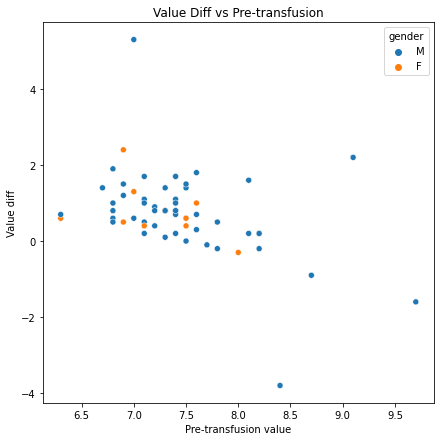

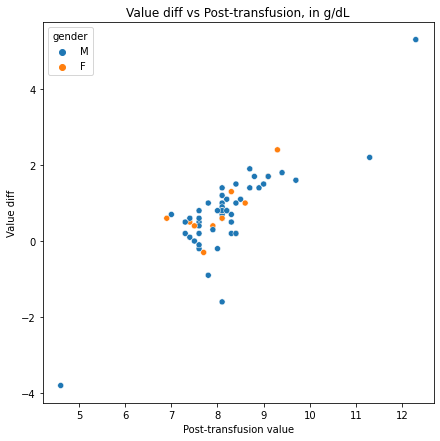

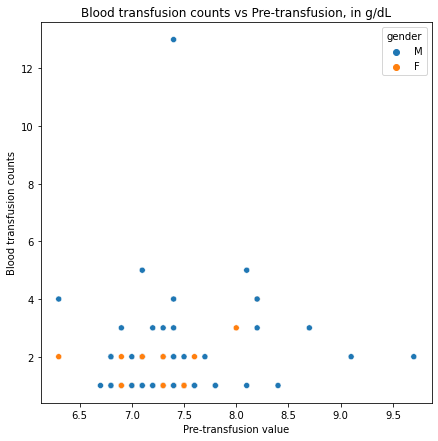

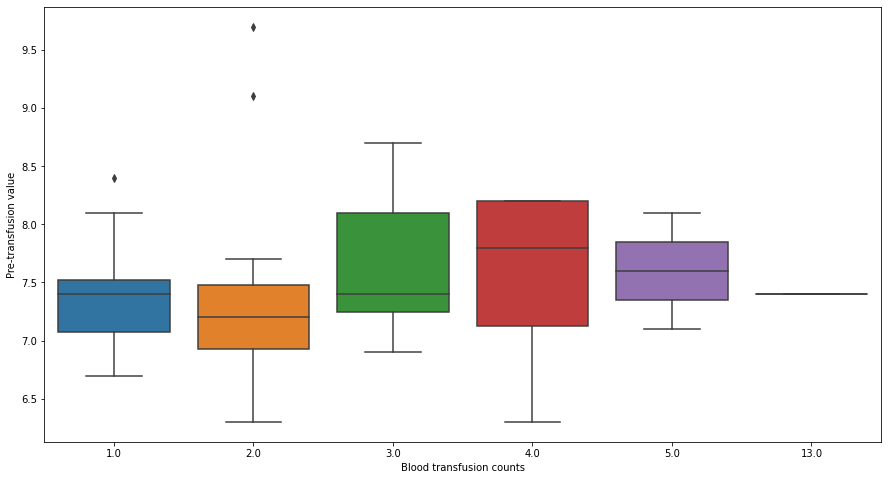

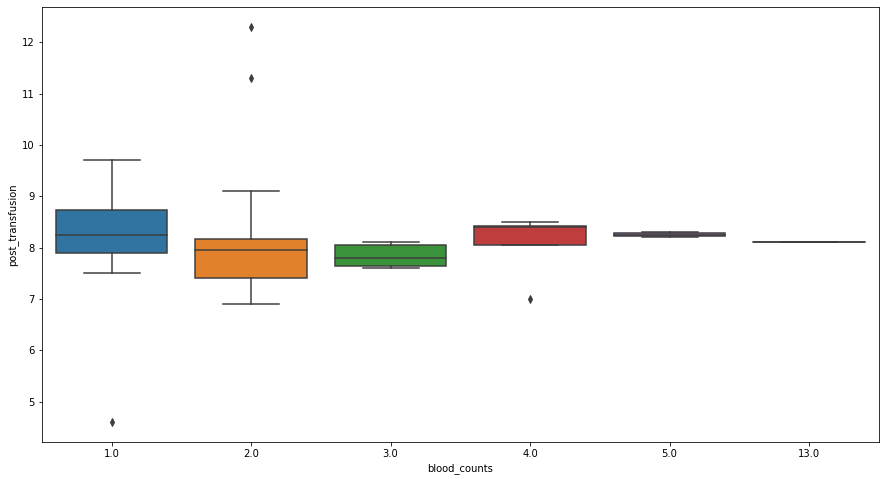

/var/folders/mx/55zzsbtn4yscj7cmdyfv7jg80000gn/T/ipykernel_61875/71590362.py:60: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  mean= partial_fbt_time_differece_Hb.mean().pre_transfusion
/var/folders/mx/55zzsbtn4yscj7cmdyfv7jg80000gn/T/ipykernel_61875/71590362.py:60: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean= partial_fbt_time_differece_Hb.mean().pre_transfusion
/var/folders/mx/55zzsbtn4yscj7cmdyfv7jg80000gn/T/ipykernel_61875/71590362.py:60: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  mean= partial_fbt_time_differece_Hb.mean().pre_transfusion
/var/folders/mx/55zzsbtn4yscj7cmdyfv7jg80000gn/T/ipykernel_61875/7159036

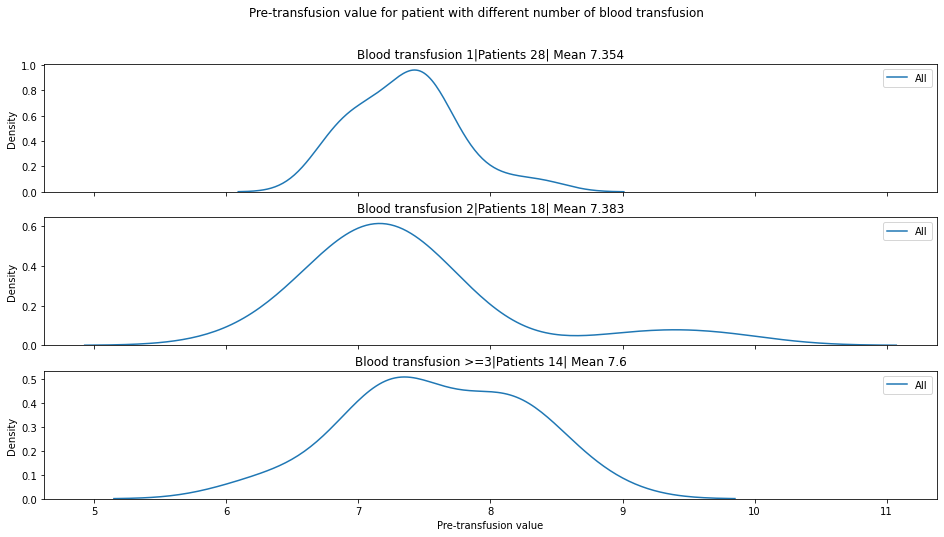

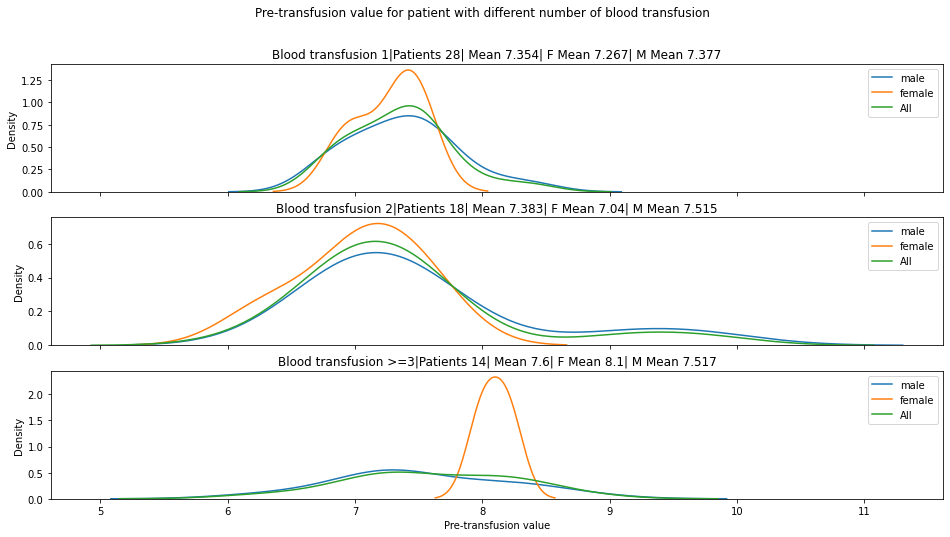

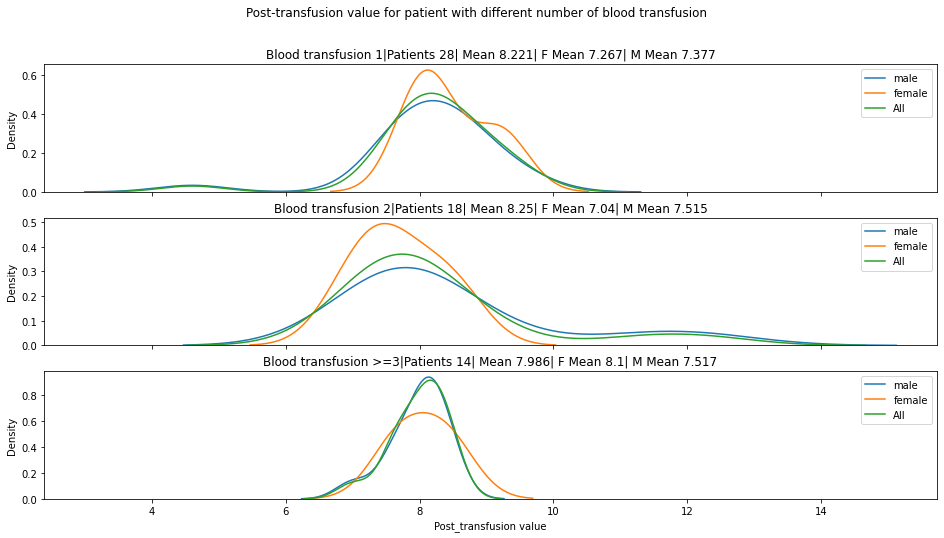

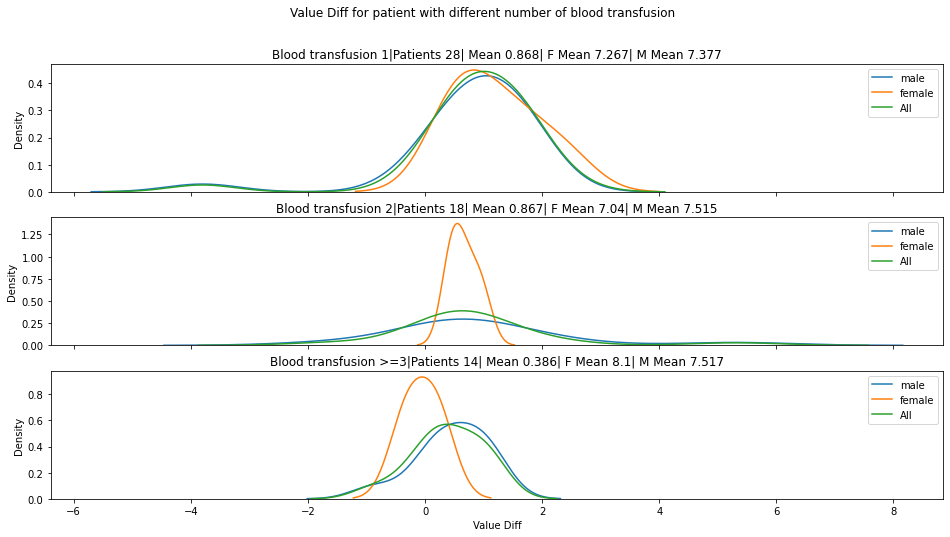

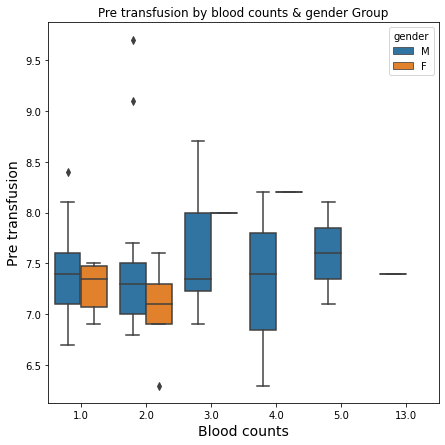

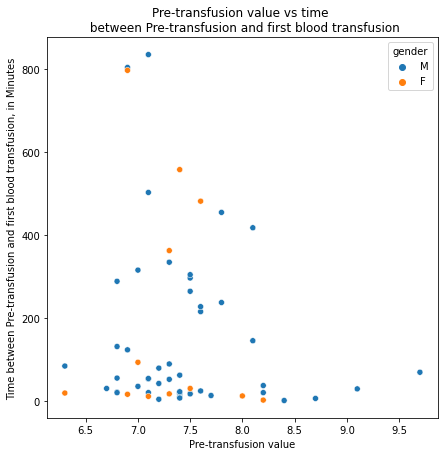

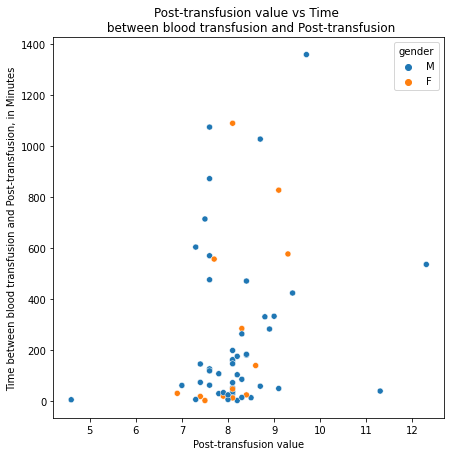

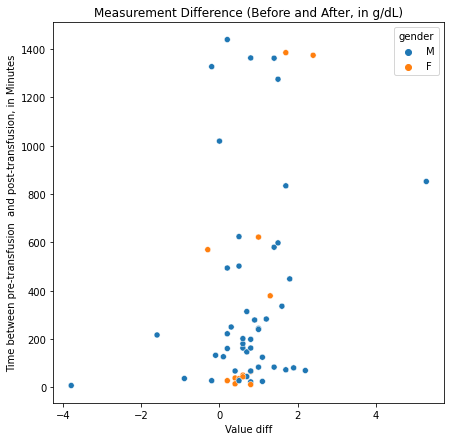

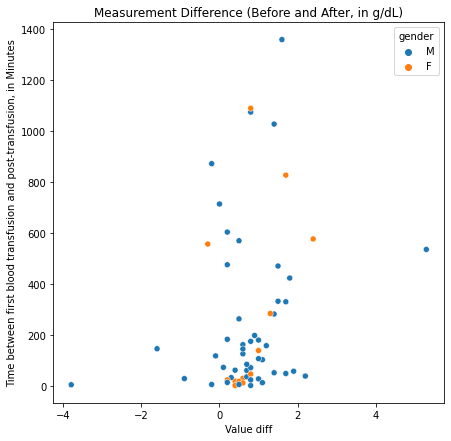

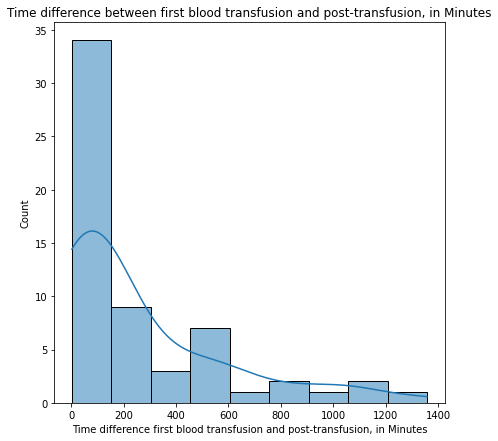

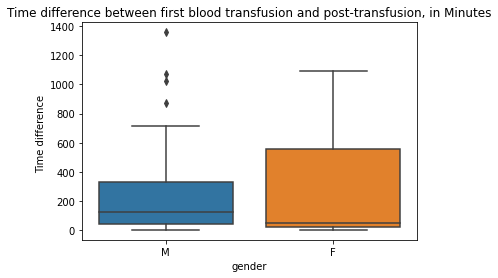

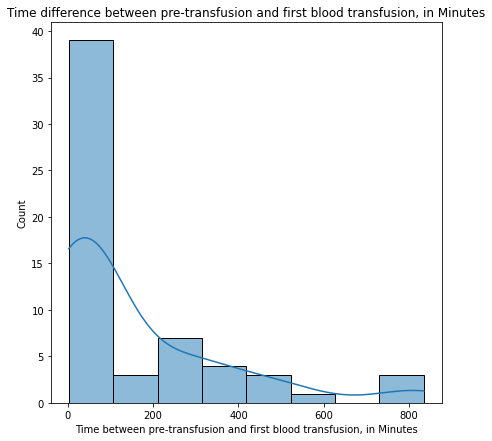

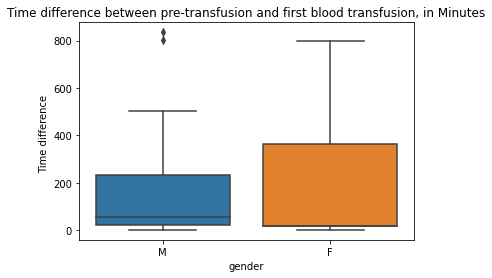

In [16]:
get_EDA(result,"Hemoglobin_EPIC")

In [50]:

df3 = df_bypass_surgeries.merge(df_haemoglobins, how='left', on=['ADMISSION_NUMBER','PATIENT_NUMBER']).reset_index()

df3 = df3[(df3.SPECIMEN_TAKEN_TIME < df3.START_TIME) & ((df3.SPECIMEN_TAKEN_TIME - df3.START_TIME).dt.seconds/60 <= 1440)][['ADMISSION_NUMBER', 'HAEMOGLOBIN_NUMBER', 'PATIENT_NUMBER']].groupby(["ADMISSION_NUMBER", "PATIENT_NUMBER"]).nunique().reset_index()
df3 = df3.join(df_patients.set_index("PATIENT_NUMBER"), on="PATIENT_NUMBER")[['ADMISSION_NUMBER', 'HAEMOGLOBIN_NUMBER', 'Gender']].rename(columns={"ADMISSION_NUMBER": "hadm_id", "Gender": "gender", "HAEMOGLOBIN_NUMBER": "counts"})


hemoglobin_24h_count =df3
#np.unique(df3.counts)

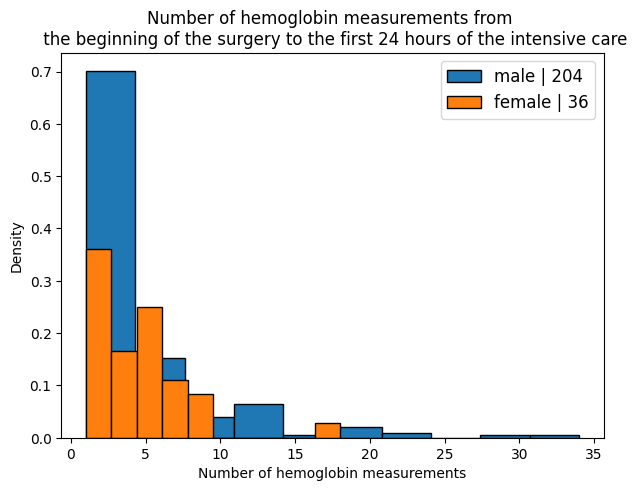

In [54]:
plt.figure(figsize=(7,5))
# male_Hb = hemoglobin_24h_count[hemoglobin_24h_count.gender == 'M']
# sns.distplot(male_Hb['counts'], label='male')

# female_Hb =hemoglobin_24h_count[hemoglobin_24h_count.gender == 'F']
# sns.distplot(female_Hb['counts'],label='female')

female = hemoglobin_24h_count.loc[hemoglobin_24h_count.gender == 'F' ].counts
male = hemoglobin_24h_count.loc[hemoglobin_24h_count.gender == 'M' ].counts

plt.hist(male,   weights=np.ones_like(male) / len(male),edgecolor="black",label= f"male | {len(hemoglobin_24h_count.loc[hemoglobin_24h_count.gender == 'M'])}")
plt.hist(female, weights=np.ones_like(female) / len(female), edgecolor="black",label= f"female | {len(hemoglobin_24h_count.loc[hemoglobin_24h_count.gender == 'F'])}")
    



plt.legend(prop={'size': 12})
plt.title('Number of hemoglobin measurements from \n the beginning of the surgery to the first 24 hours of the intensive care')
plt.xlabel('Number of hemoglobin measurements')
plt.ylabel('Density')
plt.savefig(f'Additional_Hb_plots/EPIC_histplot_numberOfHBmeasurement24H_gender.png')
plt.show()

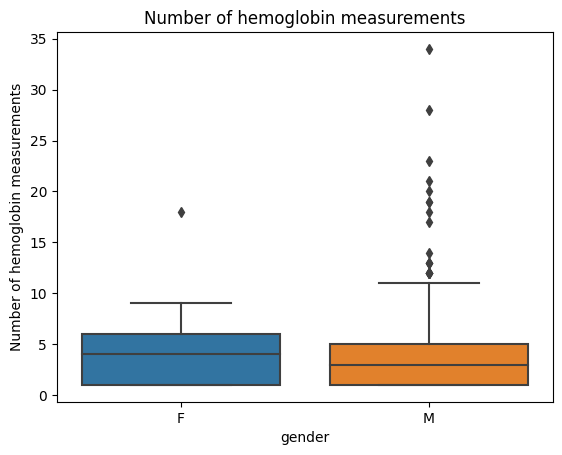

In [16]:
sns.boxplot(x="gender", y='counts', data=hemoglobin_24h_count)
plt.title("Number of hemoglobin measurements")
plt.ylabel('Number of hemoglobin measurements')
plt.savefig(f'Additional_Hb_plots/EPIC_boxplot_numberOfHBmeasurement24H_gender.png')
plt.show()